In [2]:
import pandas as pd
import numpy as np, os
import matplotlib.pyplot as plt

from pathlib import Path

import gbd_mapping as gm
from vivarium import Artifact

from db_queries import get_ids, get_outputs, get_population, get_covariate_estimates
from get_draws.api import get_draws

!date
!whoami
!pwd

ModuleNotFoundError: No module named 'gbd_mapping'

In [ ]:
age_mapping = pd.read_csv(f"../age_bins.csv")  # downloaded with a different environment
# using vivarium_inputs.utility_data.get_age_bins;
# see also https://shiny.ihme.washington.edu/content/273/
# TODO: refactor this so that it does not require an extra .csv file
age_mapping

,Unnamed: 0,age_group_id,age_group_name,age_start,age_end
0,5,5,0 to 5,0.0,5.0
1,6,6,5 to 9,5.0,10.0
2,7,7,10 to 14,10.0,15.0
3,8,8,15 to 19,15.0,20.0
4,9,9,20 to 24,20.0,25.0
5,10,10,25 to 29,25.0,30.0
6,11,11,30 to 34,30.0,35.0
7,12,12,35 to 39,35.0,40.0
8,13,13,40 to 44,40.0,45.0
9,14,14,45 to 49,45.0,50.0


## V&V List from Docs 

    - Verify that all simulants in the model have AD (i.e., all recorded person-time is in one of the “AD” states, not the “susceptible” state)
    - Verify that there are simulant person-years of BBBM-AD, MCI-AD, and AD-dementia for every year and age group of simulation
    - Verify that there are transitions between AD states are at the expected rates
    - Verify other sim mortality against artifact (ACMR - CSMR)
    - Verify Alzheimer’s EMR against artifact
    - Verify the number of new AD-demential cases per year against the AD population model

# Load Data

In [ ]:
# %cd /mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/

In [ ]:
locations = [
    #     'united_states_of_america',
    #              'china',
    #              'brazil',
    #              'japan',
    "sweden",
    #              'united_kingdom',
]


results_dirs = [
    "/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/results/abie_consistent_model_test/sweden/2025_10_24_14_18_11//results/"
]

artifact_dirs = [
    "/mnt/share/homes/abie/projects/2025/vivarium_csu_alzheimers/sweden.hdf"
]
artifact_dirs

['/mnt/share/homes/abie/projects/2025/vivarium_csu_alzheimers/sweden.hdf']

In [ ]:
[x for x in os.listdir(results_dirs[0]) if "parquet" in x]

['counts_newly_eligible_for_bbbm_testing.parquet',
 'deaths.parquet',
 'counts_new_simulants.parquet',
 'ylls.parquet',
 'person_time_eligible_for_bbbm_testing.parquet',
 'transition_count_alzheimers_disease_and_other_dementias.parquet',
 'transition_count_treatment.parquet',
 'ylds.parquet',
 'counts_bbbm_tests.parquet',
 'person_time_treatment.parquet',
 'person_time_alzheimers_disease_and_other_dementias.parquet',
 'person_time_ever_eligible_for_bbbm_testing.parquet',
 'counts_baseline_tests_among_eligible.parquet']

In [ ]:
# age_group_ids = [11,12,13,14,15,16,17,18,19,20,30,31,32,33]
# art = Artifact(artifact_dirs[0],
#                filter_terms = ['year_start==2021']  # FIXME: make this work even without filter_terms
#               )

# age_dictionary = pd.DataFrame()
# age_dictionary['age_group_id'] = age_group_ids
# age_dictionary = age_dictionary.merge(get_ids('age_group'), on='age_group_id')
# age_dictionary['age_group'] = age_dictionary.age_group_name.str.lower().str.replace(' ', '_')
# artifact = art.load('population.structure').reset_index()
# artifact = artifact.loc[artifact.age_start > 29].reset_index()
# age_dictionary['age_start'] = artifact.age_start
# age_dictionary['age_end'] = artifact.age_end

# # tweak final row to be named age group 95_plus
# assert age_dictionary.loc[13, 'age_group'] == '95_to_99'
# age_dictionary.loc[13, 'age_group'] = '95_plus'

# age_dictionary.tail()

age_dictionary = age_mapping.copy()
age_dictionary["age_group"] = age_dictionary.age_group_name.str.lower().str.replace(
    " ", "_"
)
age_dictionary

,Unnamed: 0,age_group_id,age_group_name,age_start,age_end,age_group
0,5,5,0 to 5,0.0,5.0,0_to_5
1,6,6,5 to 9,5.0,10.0,5_to_9
2,7,7,10 to 14,10.0,15.0,10_to_14
3,8,8,15 to 19,15.0,20.0,15_to_19
4,9,9,20 to 24,20.0,25.0,20_to_24
5,10,10,25 to 29,25.0,30.0,25_to_29
6,11,11,30 to 34,30.0,35.0,30_to_34
7,12,12,35 to 39,35.0,40.0,35_to_39
8,13,13,40 to 44,40.0,45.0,40_to_44
9,14,14,45 to 49,45.0,50.0,45_to_49


In [ ]:
age_group_ids = age_dictionary.query(
    "age_start >= 30 and age_start <= 95"
).age_group_id.values

## Verify that all simulants in the model have AD 

In [ ]:
def load_df(measure):
    data = pd.DataFrame()
    #     import pdb; pdb.set_trace()
    for results_dir in results_dirs:
        temp = pd.read_parquet(
            results_dir + measure + ".parquet",
            #                                filters=[('artifact_path', '==', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model7.0/united_states_of_america.hdf')],
            #                                nrows=1000
        )
        # just look at the baseline scenario for v&v purposes
        temp = temp[temp.scenario == "baseline"]

        # aggregate by summing value column over random seeds
        #         print(temp.columns)
        #         import pdb; pdb.set_trace()
        cols = [
            c
            for c in temp.columns
            if c not in ["value", "random_seed", "treatment", "artifact_path"]
        ]
        temp = temp.groupby(cols)["value"].sum().reset_index()

        temp["location"] = locations[results_dirs.index(results_dir)].title()
        temp["event_year"] = temp["event_year"].astype(int)
        data = pd.concat([data, temp], ignore_index=True)
    return data

In [ ]:
person_time = load_df("person_time_alzheimers_disease_and_other_dementias")
person_time

/tmp/ipykernel_3574311/642622834.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = temp.groupby(cols)['value'].sum().reset_index()


,measure,entity_type,entity,sub_entity,age_group,event_year,sex,input_draw_number,scenario,input_draw,value,location
0,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2025,Female,2,baseline,2,0.000000,Sweden
1,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2025,Female,2,baseline,13,0.000000,Sweden
2,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2025,Female,2,baseline,24,0.000000,Sweden
3,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2025,Female,2,baseline,41,0.000000,Sweden
4,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2025,Female,2,baseline,46,0.000000,Sweden
...,...,...,...,...,...,...,...,...,...,...,...,...
2024995,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state,95_plus,2060,Male,499,baseline,446,0.000000,Sweden
2024996,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state,95_plus,2060,Male,499,baseline,457,0.000000,Sweden
2024997,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state,95_plus,2060,Male,499,baseline,460,0.000000,Sweden
2024998,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state,95_plus,2060,Male,499,baseline,480,0.000000,Sweden


In [ ]:
person_time.loc[
    person_time.sub_entity == "susceptible_to_alzheimers_disease_and_other_dementias"
].value.sum()

0.0

In [ ]:
assert (
    person_time.loc[
        person_time.sub_entity
        == "susceptible_to_alzheimers_disease_and_other_dementias"
    ].value.sum()
    == 0
), "should be zero years of person-time susceptible"

# Verify that there *are* simulants in BBBM-AD and MCI-AD for all ages and years

In [ ]:
person_time.groupby("sub_entity").value.sum()

/tmp/ipykernel_3574311/1434696413.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  person_time.groupby('sub_entity').value.sum()


sub_entity
alzheimers_blood_based_biomarker_state        3.147588e+07
alzheimers_disease_state                      8.459939e+07
alzheimers_mild_cognitive_impairment_state    2.378073e+07
Name: value, dtype: float64

In [ ]:
person_time.groupby(
    ["location", "event_year", "age_group", "sub_entity"]
).value.sum().unstack()

/tmp/ipykernel_3574311/63004212.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  person_time.groupby(['location', 'event_year', 'age_group', 'sub_entity']).value.sum().unstack()


sub_entity                     alzheimers_blood_based_biomarker_state  \
location event_year age_group                                           
Sweden   2025       25_to_29                                 0.000000   
                    30_to_34                               996.079398   
                    35_to_39                              1347.871321   
                    40_to_44                              1310.001369   
                    45_to_49                              4233.960301   
...                                                               ...   
         2060       75_to_79                            204927.764545   
                    80_to_84                            231400.355921   
                    85_to_89                            160095.222450   
                    90_to_94                             73847.901437   
                    95_plus                              25801.396304   

sub_entity                     alzheimers_disease_state  \
location event_year age_group                             
Sweden   2025       25_to_29                   0.000000   
                    30_to_34                 337.341547   
                    35_to_39                 417.067762   
                    40_to_44                 478.357290   
                    45_to_49                 755.405886   
...                                                 ...   
         2060       75_to_79              448367.775496   
                    80_to_84              679328.142368   
                    85_to_89              697803.197810   
                    90_to_94              447182.346338   
                    95_plus               227068.731006   

sub_entity                     alzheimers_mild_cognitive_impairment_state  
location event_year age_group                                              
Sweden   2025       25_to_29                                     0.000000  
                    30_to_34                                   816.695414  
                    35_to_39                                   530.179329  
                    40_to_44                                   557.086927  
                    45_to_49                                  1360.328542  
...                                                                   ...  
         2060       75_to_79                                140972.391513  
                    80_to_84                                180992.958248  
                    85_to_89                                147198.012320  
                    90_to_94                                 76861.054073  
                    95_plus                                  31309.979466  

[540 rows x 3 columns]

In [ ]:
# assert np.all(person_time[~person_time.age_group.isin(['25_to_29', '30_to_34', '35_to_40'])
#                          ].groupby(['location', 'event_year', 'age_group', 'sub_entity']).value.sum().unstack().fillna(0) > 0)

## Verify that there are no transitions out of susceptible state during the simulation 

In [ ]:
trans = load_df("transition_count_alzheimers_disease_and_other_dementias")
trans.loc[
    trans.sub_entity
    == "susceptible_to_alzheimers_disease_and_other_dementias_to_alzheimers_disease_and_other_dementias"
].value.sum()

/tmp/ipykernel_3574311/642622834.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = temp.groupby(cols)['value'].sum().reset_index()


0.0

In [ ]:
# assert trans.loc[trans.sub_entity == 'susceptible_to_alzheimers_disease_and_other_dementias_to_alzheimers_disease_and_other_dementias'].value.sum() == 0, \
#        'should be zero transitions from susceptible to with-condition'

# And that there *are* transitions out of other states for all ages

In [ ]:
# assert np.all(trans.groupby(['location', 'event_year', 'age_group', 'sub_entity']).value.sum().unstack() > 0)

## Next look at the transition rates and approximate durations for BBBM and MCI

In [ ]:
out_counts = (
    trans.groupby(["location", "event_year", "age_group", "sub_entity"])
    .value.sum()
    .unstack()
)
out_counts.columns = [c.split("_to_")[0] for c in out_counts.columns]
out_counts

/tmp/ipykernel_3574311/3544767031.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out_counts = trans.groupby(['location', 'event_year', 'age_group', 'sub_entity']).value.sum().unstack()


alzheimers_blood_based_biomarker_state  \
location event_year age_group                                           
Sweden   2025       25_to_29                                      0.0   
                    30_to_34                                    149.0   
                    35_to_39                                    174.0   
                    40_to_44                                    194.0   
                    45_to_49                                    600.0   
...                                                               ...   
         2060       75_to_79                                  30086.0   
                    80_to_84                                  35243.0   
                    85_to_89                                  24997.0   
                    90_to_94                                  11462.0   
                    95_plus                                    4211.0   

                               alzheimers_mild_cognitive_impairment_state  
location event_year age_group                                              
Sweden   2025       25_to_29                                          0.0  
                    30_to_34                                        197.0  
                    35_to_39                                        138.0  
                    40_to_44                                        161.0  
                    45_to_49                                        358.0  
...                                                                   ...  
         2060       75_to_79                                      36532.0  
                    80_to_84                                      46146.0  
                    85_to_89                                      37196.0  
                    90_to_94                                      18339.0  
                    95_plus                                        7318.0  

[540 rows x 2 columns]

In [ ]:
out_rates = (
    out_counts
    / person_time.groupby(["location", "event_year", "age_group", "sub_entity"])
    .value.sum()
    .unstack()
)
out_rates["alzheimers_blood_based_biomarker_state"].unstack()

/tmp/ipykernel_3574311/3571420227.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out_rates = out_counts / person_time.groupby(['location', 'event_year', 'age_group', 'sub_entity']).value.sum().unstack()


age_group            25_to_29  30_to_34  35_to_39  40_to_44  45_to_49  \
location event_year                                                     
Sweden   2025             NaN  0.149586  0.129092  0.148091  0.141711   
         2026             NaN  0.165054  0.157521  0.141698  0.158830   
         2027             NaN  0.208934  0.177263  0.143086  0.147821   
         2028             NaN  0.150371  0.183794  0.143426  0.150742   
         2029             NaN  0.253294  0.200687  0.125166  0.153376   
         2030             NaN  0.000000  0.179138  0.128310  0.151196   
         2031             NaN       NaN  0.181724  0.144200  0.146134   
         2032             NaN       NaN  0.250859  0.143104  0.151439   
         2033             NaN       NaN  0.205427  0.121587  0.159553   
         2034             NaN       NaN  0.243257  0.128211  0.153891   
         2035             NaN       NaN  0.000000  0.138150  0.155462   
         2036             NaN       NaN  0.000000  0.128626  0.159769   
         2037             NaN       NaN  2.006868  0.126233  0.158698   
         2038             NaN       NaN       NaN  0.127826  0.152769   
         2039             NaN       NaN  0.000000  0.129004  0.156962   
         2040             NaN       NaN  0.668956  0.126842  0.164035   
         2041             NaN       NaN  0.000000  0.130707  0.152521   
         2042             NaN       NaN  0.000000  0.119446  0.145350   
         2043             NaN       NaN       NaN  0.140574  0.146591   
         2044             NaN       NaN  0.000000  0.118527  0.157176   
         2045             NaN       NaN  0.000000  0.124686  0.149034   
         2046             NaN       NaN  0.000000  0.130210  0.147295   
         2047             NaN       NaN  0.286695  0.120838  0.161208   
         2048             NaN       NaN  0.334478  0.125540  0.159607   
         2049             NaN       NaN  0.501717  0.127376  0.154760   
         2050             NaN       NaN  0.000000  0.120052  0.156449   
         2051             NaN       NaN  0.000000  0.126285  0.146479   
         2052             NaN       NaN  0.401374  0.131501  0.149661   
         2053             NaN       NaN  0.000000  0.120657  0.155920   
         2054             NaN       NaN  0.000000  0.132532  0.154527   
         2055             NaN       NaN  0.000000  0.121879  0.147034   
         2056             NaN       NaN  0.000000  0.138107  0.152141   
         2057             NaN       NaN  0.000000  0.119724  0.156051   
         2058             NaN       NaN  0.000000  0.126601  0.152699   
         2059             NaN       NaN  1.003434  0.132416  0.161015   
         2060             NaN       NaN  0.000000  0.111937  0.151040   

age_group            50_to_54  55_to_59  60_to_64  65_to_69  70_to_74  \
location event_year                                                     
Sweden   2025        0.152927  0.156391  0.148596  0.144311  0.146310   
         2026        0.151699  0.154523  0.137435  0.144207  0.147729   
         2027        0.162733  0.153007  0.143915  0.142374  0.148491   
         2028        0.169382  0.150920  0.142276  0.140858  0.146012   
         2029        0.169468  0.149735  0.140913  0.140156  0.144689   
         2030        0.161949  0.151700  0.138470  0.139322  0.143980   
         2031        0.174556  0.157042  0.136570  0.138787  0.146325   
         2032        0.156011  0.154117  0.139408  0.141830  0.144693   
         2033        0.155945  0.143074  0.137539  0.137430  0.144053   
         2034        0.161269  0.144739  0.138249  0.137868  0.143911   
         2035        0.157513  0.146428  0.143098  0.141270  0.143729   
         2036        0.159250  0.157332  0.140208  0.142096  0.144447   
         2037        0.167986  0.145812  0.141244  0.140993  0.143947   
         2038        0.162877  0.148919  0.136333  0.138978  0.142773   
         2039        0.161365  0.155310  0.138673  0.1379

In [ ]:
1 / 3.85

0.2597402597402597

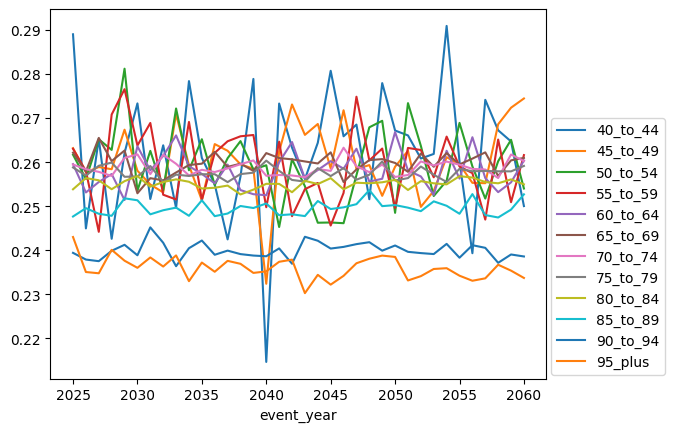

In [ ]:
t = out_rates["alzheimers_mild_cognitive_impairment_state"].unstack()
t.loc["Sweden"].iloc[:, 3:].plot()
plt.legend(loc=(1.01, 0.01))

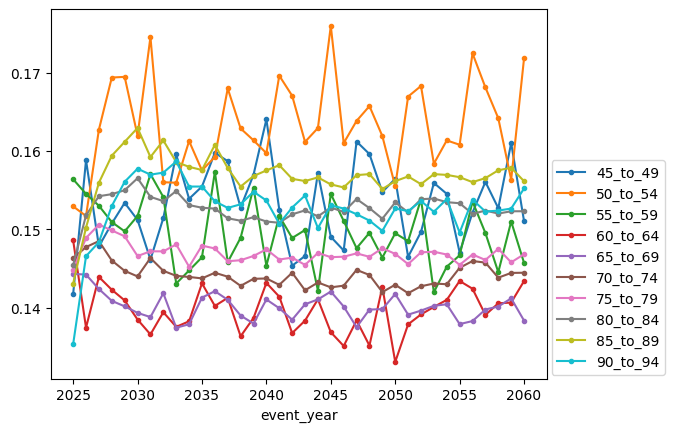

In [ ]:
t = out_rates["alzheimers_blood_based_biomarker_state"].unstack()
t.loc["Sweden"].iloc[:, 4:14].plot(marker=".")
plt.legend(loc=(1.01, 0.01))

In [ ]:
# prevalence \approx incidence * duration
prevalence_count = (
    person_time.groupby(["location", "event_year", "age_group", "sub_entity"])
    .value.sum()
    .unstack()
)

mci_duration_est = (
    prevalence_count["alzheimers_mild_cognitive_impairment_state"]
    / out_counts["alzheimers_blood_based_biomarker_state"]
)
mci_duration_est

/tmp/ipykernel_3574311/1452923819.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prevalence_count = person_time.groupby(['location', 'event_year', 'age_group', 'sub_entity']).value.sum().unstack()


location  event_year  age_group
Sweden    2025        25_to_29          NaN
                      30_to_34     5.481177
                      35_to_39     3.047008
                      40_to_44     2.871582
                      45_to_49     2.267214
                                     ...   
          2060        75_to_79     4.685648
                      80_to_84     5.135572
                      85_to_89     5.888627
                      90_to_94     6.705728
                      95_plus      7.435284
Length: 540, dtype: float64

In [ ]:
new_sims = (
    load_df("counts_new_simulants")
    .groupby(
        [
            "location",
            "event_year",
            "age_group",
        ]
    )
    .value.sum()
)
# new_sims


bbbm_duration_est = (
    prevalence_count["alzheimers_blood_based_biomarker_state"] / new_sims
)
bbbm_duration_est

/tmp/ipykernel_3574311/642622834.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = temp.groupby(cols)['value'].sum().reset_index()
/tmp/ipykernel_3574311/555533763.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  new_sims = load_df('counts_new_simulants').groupby(['location', 'event_year', 'age_group', ]).value.sum()


location  event_year  age_group
Sweden    2025        25_to_29             NaN
                      30_to_34             inf
                      35_to_39     1347.871321
                      40_to_44        0.694961
                      45_to_49        8.434184
                                      ...     
          2060        75_to_79        1.809820
                      80_to_84        2.648996
                      85_to_89        3.161813
                      90_to_94        2.380654
                      95_plus              inf
Length: 540, dtype: float64

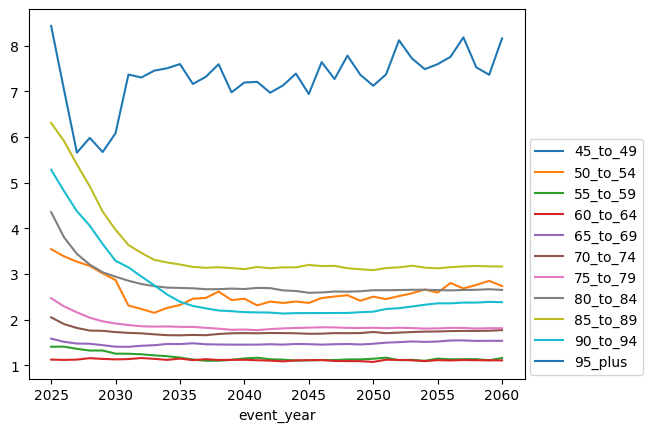

In [ ]:
t = bbbm_duration_est.unstack()
t.loc["Sweden"].iloc[:, 4:].plot()
plt.legend(loc=(1.01, 0.01))

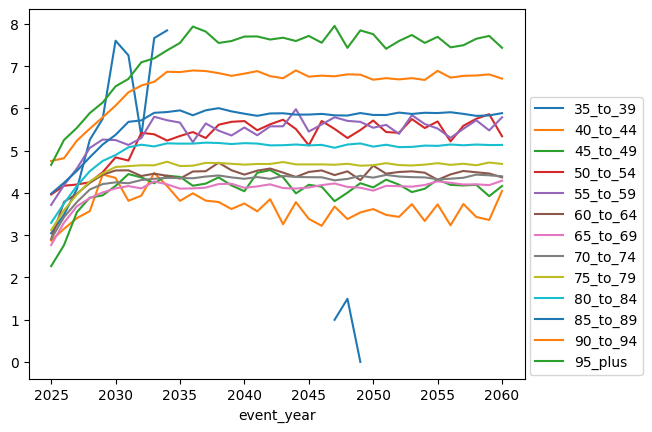

In [ ]:
t = mci_duration_est.unstack()
t.loc["Sweden"].iloc[:, 2:].plot()
plt.legend(loc=(1.01, 0.01))

## Verify Other Cause Mortality in  Sim against artifact (ACMR - CSMR)

In [ ]:
%%time

cols = ['input_draw','event_year','location','age_group','sex']

def calculate_ocmr():
    person_time_total = load_df('person_time_alzheimers_disease_and_other_dementias')
    total_pt = person_time_total.groupby(cols).sum(numeric_only=True)

    deaths = load_df('deaths')
    other_deaths = deaths[deaths.sub_entity == 'other_causes'].groupby(cols).sum(numeric_only=True)

    ocmr = (other_deaths / total_pt)[['value']].reset_index()

    ocmr2 = ocmr.merge(age_dictionary, on=['age_group'])
    ocmr3 = ocmr2.loc[ocmr2['age_group_id']#.isin(age_group_ids)
                     ]
    ocmr4 = ocmr2.groupby([c for c in cols if c != 'input_draw'] + ['age_start']).describe(percentiles=[0.025,0.975])['value'].reset_index()
    return ocmr4

sim_ocmr = calculate_ocmr()

/tmp/ipykernel_3574311/642622834.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = temp.groupby(cols)['value'].sum().reset_index()
<timed exec>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/tmp/ipykernel_3574311/642622834.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = temp.groupby(cols)['value'].sum().reset_index()
<timed exec>:8: FutureWarning: The default of observed=False is deprecated and wil

CPU times: user 12.4 s, sys: 2.24 s, total: 14.7 s
Wall time: 11.1 s


In [ ]:
art_ocmr = pd.DataFrame()
for artifact_dir in artifact_dirs:
    art = Artifact(artifact_dir)

    # TODO: consider better ways to broadcast years from excess mx
    a = art.load(f"cause.all_causes.cause_specific_mortality_rate")
    b = art.load(
        f"cause.alzheimers_disease_and_other_dementias.cause_specific_mortality_rate"
    )

    data1 = (a - b.droplevel(["year_start", "year_end"])).dropna()
    data2 = (
        data1.apply(pd.DataFrame.describe, percentiles=[0.025, 0.975], axis=1)
        .filter(["mean", "2.5%", "97.5%"])
        .reset_index()
    )
    data3 = data2.merge(age_dictionary, on=["age_start", "age_end"])
    data4 = data3  # .loc[data3['age_group_id'].isin(age_group_ids)]
    data4["measure"] = "acmr"
    data4["location"] = locations[artifact_dirs.index(artifact_dir)].title()
    art_ocmr = pd.concat([art_ocmr, data4])
art_ocmr

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,Unnamed: 0,age_group_id,age_group_name,age_group,measure,location
0,Female,5.0,10.0,2022,2023,0.000056,0.000049,0.000070,6,6,5 to 9,5_to_9,acmr,Sweden
1,Female,5.0,10.0,2023,2024,0.000055,0.000047,0.000069,6,6,5 to 9,5_to_9,acmr,Sweden
2,Female,5.0,10.0,2024,2025,0.000054,0.000046,0.000069,6,6,5 to 9,5_to_9,acmr,Sweden
3,Female,5.0,10.0,2025,2026,0.000053,0.000045,0.000068,6,6,5 to 9,5_to_9,acmr,Sweden
4,Female,5.0,10.0,2026,2027,0.000053,0.000044,0.000068,6,6,5 to 9,5_to_9,acmr,Sweden
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1097,Male,95.0,125.0,2046,2047,0.177785,0.127205,0.219768,24,235,95 plus,95_plus,acmr,Sweden
1098,Male,95.0,125.0,2047,2048,0.177683,0.128545,0.221186,24,235,95 plus,95_plus,acmr,Sweden
1099,Male,95.0,125.0,2048,2049,0.177818,0.127315,0.220385,24,235,95 plus,95_plus,acmr,Sweden
1100,Male,95.0,125.0,2049,2050,0.178105,0.127624,0.221148,24,235,95 plus,95_plus,acmr,Sweden


In [ ]:
art_data = art_ocmr
location = "Sweden"
sex = "Female"
year = 2030
# art_data.loc[(art_data.location == location) & (art_data.sex == sex) & (art_data.year_start == year)]

In [ ]:
def age_group_plot(measure, sim_data, art_data, art_year=None):
    for location in sim_data.location.unique():
        fig, ax = plt.subplots(nrows=3, sharex=True, sharey=True)
        for i, year in enumerate([2030, 2040, 2050]):
            for j, sex in enumerate(sim_data.sex.unique()):
                color = f"C{j}"
                plot_data = sim_data.loc[
                    (sim_data.location == location)
                    & (sim_data.event_year == year)
                    & (sim_data.sex == sex)
                ]
                if art_year is None:
                    art_plot = art_data.loc[
                        (art_data.location == location)
                        & (art_data.sex == sex)
                        & (art_data.year_start == year)
                    ]
                else:
                    art_plot = art_data.loc[
                        (art_data.location == location)
                        & (art_data.sex == sex)
                        & (art_data.year_start == art_year)
                    ]

                ax[i].fill_between(
                    plot_data.age_start,
                    plot_data["2.5%"],
                    plot_data["97.5%"],
                    alpha=0.2,
                    color=color,
                )
                ax[i].fill_between(
                    art_plot.age_start,
                    art_plot["2.5%"],
                    art_plot["97.5%"],
                    alpha=0.2,
                    color=color,
                )

                ax[i].plot(
                    art_plot.age_start,
                    art_plot["mean"],
                    linestyle="--",
                    label=f"Artifact {sex}",
                    color=color,
                    linewidth=3,
                )
                ax[i].plot(
                    plot_data.age_start,
                    plot_data["mean"],
                    label=f"Simulation {sex}",
                    color=color,
                )

                if i == 0:
                    ax[i].set_title(f"{measure} in {location}")

                ax[i].text(
                    0.5,
                    0.95,
                    f"{year}",
                    va="top",
                    ha="center",
                    transform=ax[i].transAxes,
                )
                #                 ax[i].tick_params(axis='x', labelrotation=90)

                if i == 2:
                    ax[i].set_xlabel("Age Group")

                if i == 1:
                    ax[i].set_ylabel(f"{measure}")
                    ax[i].legend(loc=(1.01, 0))
        #                 ax[i].semilogy()
        plt.subplots_adjust(hspace=0)

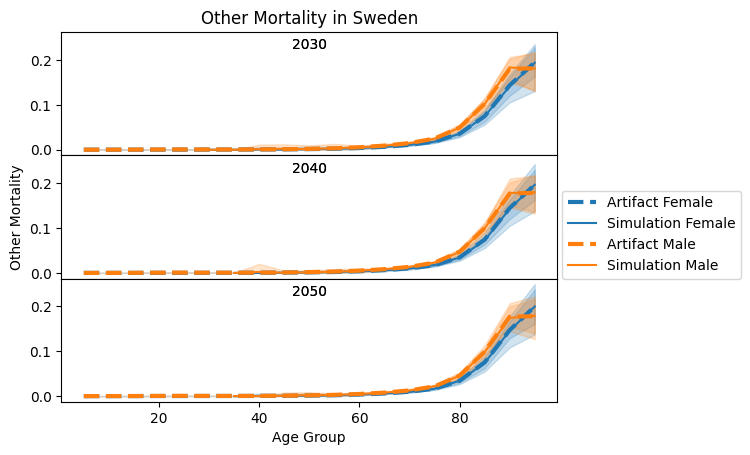

In [ ]:
age_group_plot("Other Mortality", sim_ocmr, art_ocmr)

In [ ]:
def over_time_plot(measure, sim_data, age_start):
    for location in sim_data.location.unique():
        for sex in sim_data.sex.unique():
            plot_data = sim_data.loc[
                (sim_data.location == location)
                & (sim_data.age_start == age_start)
                & (sim_data.sex == sex)
            ]

            plt.plot(plot_data.event_year, plot_data["mean"], label=f"Simulation {sex}")
            plt.fill_between(
                plot_data.event_year, plot_data["2.5%"], plot_data["97.5%"], alpha=0.2
            )

            plt.title(
                f"{measure} in {location} Over Time Among Age Start Group {age_start}"
            )
            plt.tick_params(axis="x", labelrotation=90)
            plt.xlabel("Year")
            plt.ylabel(f"{measure}")
            plt.legend()
        plt.figure()

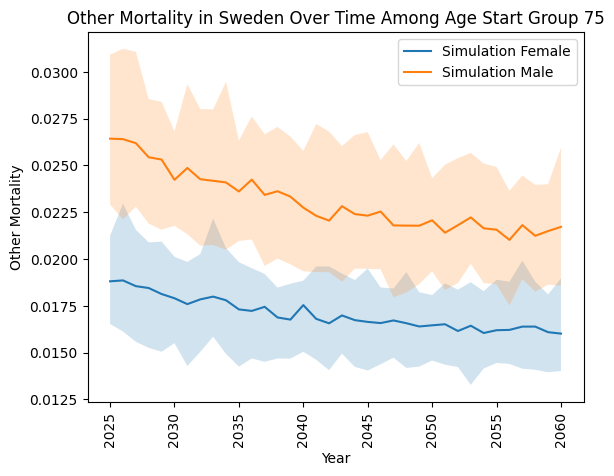

<Figure size 640x480 with 0 Axes>

In [ ]:
over_time_plot("Other Mortality", sim_ocmr, 75)

## Validate Alzheimer’s EMR against GBD

In [ ]:
cols = ["input_draw", "event_year", "location", "age_group", "sex"]


def calculate_emr():
    person_time_total = load_df("person_time_alzheimers_disease_and_other_dementias")
    infected = (
        person_time_total.loc[
            person_time_total.sub_entity == "alzheimers_disease_state"
        ]
        .groupby(cols)
        .sum(numeric_only=True)
    )
    assert len(infected) > 0

    deaths0 = load_df("deaths")
    deaths = (
        deaths0.loc[deaths0.sub_entity == "alzheimers_disease_state"]
        .groupby(cols)
        .sum(numeric_only=True)
    )
    assert len(deaths) > 0

    mr = (deaths / infected)[["value"]].reset_index()

    mr = mr.merge(age_dictionary, on=["age_group"])
    mr = mr.loc[mr["age_group_id"].isin(age_group_ids)]
    mr1 = (
        mr.groupby([c for c in cols if c != "input_draw"] + ["age_start"])
        .describe(percentiles=[0.025, 0.975])["value"]
        .reset_index()
    )
    return mr1


sim_emr = calculate_emr()

/tmp/ipykernel_3574311/642622834.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = temp.groupby(cols)['value'].sum().reset_index()
/tmp/ipykernel_3574311/982211503.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ].groupby(cols).sum(numeric_only=True)
/tmp/ipykernel_3574311/642622834.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = temp.groupby(cols)['value'].sum().reset_index()
/tmp/ipykernel_357

In [ ]:
def load_artifact_cause_data(measure):
    out = pd.DataFrame()
    for artifact_dir in artifact_dirs:
        art = Artifact(artifact_dir, filter_terms=["year_start==2021"])
        data = art.load(f"cause.alzheimers_disease_and_other_dementias.{measure}")
        data = (
            data.apply(pd.DataFrame.describe, percentiles=[0.025, 0.975], axis=1)
            .filter(["mean", "2.5%", "97.5%"])
            .reset_index()
        )
        data = data.merge(age_dictionary, on=["age_start", "age_end"])
        #         data = data.loc[data['age_group_id'].isin(age_group_ids)]
        data["measure"] = measure
        data["location"] = locations[artifact_dirs.index(artifact_dir)].title()
        out = pd.concat([out, data])
    return out

In [1]:
art_emr = load_artifact_cause_data("excess_mortality_rate")
art_emr

NameError: name 'load_artifact_cause_data' is not defined

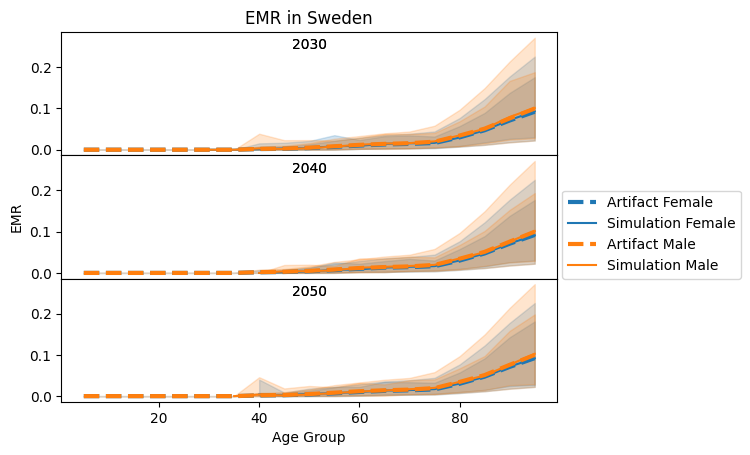

In [ ]:
age_group_plot("EMR", sim_emr, art_emr, art_year=2021)

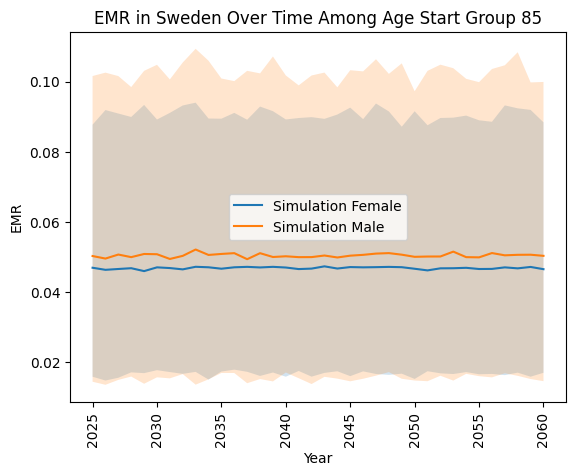

<Figure size 640x480 with 0 Axes>

In [ ]:
over_time_plot("EMR", sim_emr, 85)

## Verify the number of new simulants per year against the AD population model

In [40]:
# art.keys

In [ ]:
art_incidence_data = []
for artifact_dir in artifact_dirs:
    art = Artifact(artifact_dir)
    df = pd.merge(
        art.load("cause.alzheimers.population_incidence_rate").droplevel(
            ["year_start", "year_end"]
        ),
        art.load("population.structure"),
        left_index=True,
        right_index=True,
        suffixes=["", "_pop"],
    )
    art_incidence_data.append(df)

art_incidence_data = pd.concat(art_incidence_data)
for i in range(500):
    art_incidence_data[f"draw_{i}"] *= art_incidence_data[f"draw_{i}_pop"]
    del art_incidence_data[f"draw_{i}_pop"]

In [ ]:
scale = pd.DataFrame()
for artifact_dir in artifact_dirs:
    art = Artifact(artifact_dir)
    temp = art.load("population.structure").reset_index()
    temp["location"] = temp.location.str.replace(" ", "_").str.title()
    #     import pdb; pdb.set_trace()
    df_prev_pop = pd.merge(
        art.load("population.scaling_factor").query("year_start == 2023"),
        art.load("population.structure")
        .query("year_start==2025")
        .droplevel(["year_start", "year_end"]),
        left_index=True,
        right_index=True,
        suffixes=["_prev", "_pop"],
    )
    prev = (
        (
            df_prev_pop.filter(like="draw_").filter(like="_prev")
            * df_prev_pop.filter(like="draw_").filter(like="_pop").values
        ).mean(axis=1)
    ).sum(axis=0)
    # TODO: use draw-specific scale instead of mean

    ratio = 100_000 / (prev + 0.01)
    temp["ratio"] = ratio

    temp = temp.rename(columns={"year_start": "event_year"})
    temp = temp.merge(age_dictionary, on=["age_start", "age_end"])
    temp = temp.loc[temp["age_group_id"].isin(age_group_ids)]
    scale = pd.concat([scale, temp], ignore_index=True)
# scale

In [ ]:
scale.groupby(
    "location"
).ratio.describe() / 5  # compare to 0.0035494897066482814 in interactive sim for USA

,count,mean,std,min,25%,50%,75%,max
location,,,,,,,,
Sweden,168.0,0.112504,0.0,0.112504,0.112504,0.112504,0.112504,0.112504


In [ ]:
cols = ["input_draw", "event_year", "location", "age_group", "sex"]

new_sims = load_df("counts_new_simulants")
# new_sims

/tmp/ipykernel_3574311/642622834.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = temp.groupby(cols)['value'].sum().reset_index()


In [ ]:
trans = load_df("transition_count_alzheimers_disease_and_other_dementias")
new_ad_dementia = trans[
    trans.sub_entity
    == "alzheimers_mild_cognitive_impairment_state_to_alzheimers_disease_state"
]

/tmp/ipykernel_3574311/642622834.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = temp.groupby(cols)['value'].sum().reset_index()


In [ ]:
new_sims = new_sims.merge(
    scale[["location", "sex", "age_group", "ratio", "event_year"]]
)
new_ad_dementia = new_ad_dementia.merge(
    scale[["location", "sex", "age_group", "ratio", "event_year"]]
)

In [47]:
# new_sims

In [ ]:
new_sims["total_incidence"] = new_sims["value"] / new_sims["ratio"]
new_ad_dementia["total_incidence"] = new_ad_dementia["value"] / new_sims["ratio"]


def summarize(df):
    df = df.groupby(cols).sum(numeric_only=True)
    df = (
        df.groupby([c for c in cols if c != "input_draw"])
        .describe(percentiles=[0.025, 0.975])["total_incidence"]
        .reset_index()
    )

    df = df.merge(age_dictionary, on=["age_group"])
    df = df.loc[df["age_group_id"].isin(age_group_ids)]

    return df


new_sims_summary = summarize(new_sims)

In [49]:
new_ad_dementia_summary = summarize(new_ad_dementia)
new_ad_dementia_summary

,event_year,location,age_group,sex,count,mean,std,min,2.5%,50%,97.5%,max,Unnamed: 0,age_group_id,age_group_name,age_start,age_end
0,2025,Sweden,30_to_34,Female,25.0,8.817498,4.827204,0.000000,1.066633,8.888607,17.421670,19.554936,11,11,30 to 34,30.0,35.0
1,2025,Sweden,30_to_34,Male,25.0,5.190947,3.939168,0.000000,0.000000,5.333164,13.155139,14.221772,11,11,30 to 34,30.0,35.0
2,2025,Sweden,35_to_39,Female,25.0,6.755342,3.518212,0.000000,1.066633,7.110886,13.510683,17.777215,12,12,35 to 39,35.0,40.0
3,2025,Sweden,35_to_39,Male,25.0,3.057681,2.881152,0.000000,0.000000,1.777721,8.888607,8.888607,12,12,35 to 39,35.0,40.0
4,2025,Sweden,40_to_44,Female,25.0,7.750866,3.731804,3.555443,3.555443,5.333164,14.932860,15.999493,13,13,40 to 44,40.0,45.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
723,2050,Sweden,85_to_89,Male,25.0,754.749419,128.242695,453.318970,525.850005,759.087059,965.302747,975.969076,22,31,85 to 89,85.0,90.0
724,2050,Sweden,90_to_94,Female,25.0,841.288899,106.793179,661.312379,669.845442,840.862246,1014.012315,1015.078948,23,32,90 to 94,90.0,95.0
725,2050,Sweden,90_to_94,Male,25.0,340.042559,57.169985,257.769610,258.836243,332.433911,452.963426,492.428842,23,32,90 to 94,90.0,95.0
726,2050,Sweden,95_plus,Female,25.0,336.984878,73.101396,177.772145,199.104802,353.766569,453.318970,458.652134,24,235,95 plus,95.0,125.0


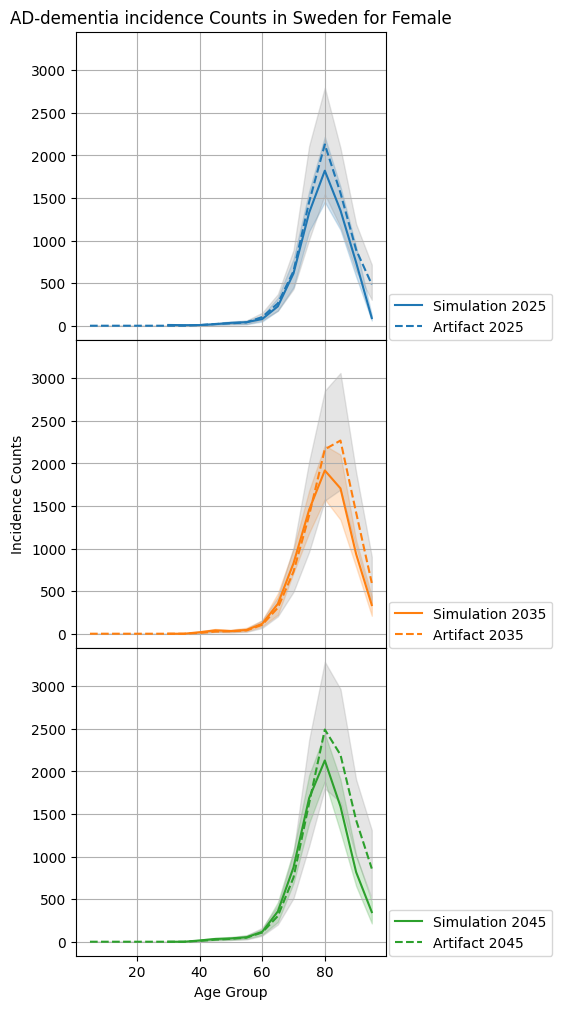

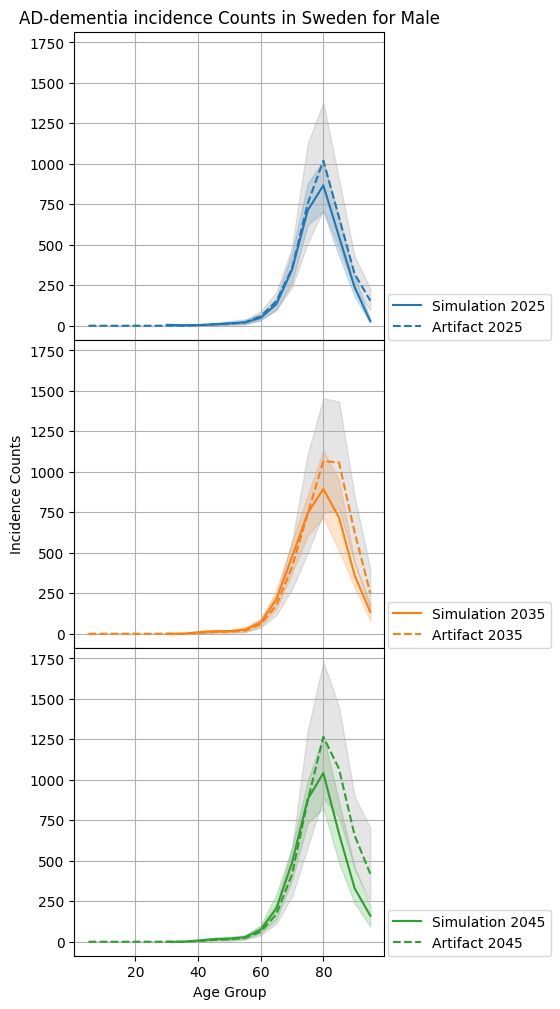

In [ ]:
for location in new_sims.location.unique():
    for sex in new_sims.sex.unique():
        fig, ax = plt.subplots(nrows=3, sharex=True, sharey=True, figsize=(4, 12))
        plt.subplots_adjust(hspace=0)
        for i, year in enumerate([2025, 2035, 2045]):
            color = f"C{i}"
            plot_data = new_ad_dementia_summary.query(
                "location == @location and event_year == @year and sex == @sex"
            )

            location_w_spaces = location.replace("_", " ").replace("Of", "of")
            art_plot = art_incidence_data.query(
                f'location == "{location_w_spaces}" and year_start == {year} and sex == "{sex}"'
            ).reset_index()

            art_plot["mean"] = art_plot.filter(like="draw_").mean(axis=1)
            art_plot["upper"] = np.percentile(
                art_plot.filter(like="draw_"), 97.5, axis=1
            )
            art_plot["lower"] = np.percentile(
                art_plot.filter(like="draw_"), 2.5, axis=1
            )

            ax[i].fill_between(
                plot_data.age_start,
                plot_data["2.5%"],
                plot_data["97.5%"],
                alpha=0.2,
                color=color,
            )
            ax[i].fill_between(
                art_plot.age_start,
                art_plot["upper"],
                art_plot["lower"],
                alpha=0.2,
                color="grey",
            )
            ax[i].plot(
                plot_data.age_start,
                plot_data["mean"],
                label=f"Simulation {year}",
                color=color,
            )
            ax[i].plot(
                art_plot.age_start,
                art_plot["mean"],
                label=f"Artifact {year}",
                color=color,
                linestyle="--",
            )
            ax[i].grid(True)
            if i == 0:
                ax[i].set_title(f"AD-dementia incidence Counts in {location} for {sex}")
            #             plt.tick_params(axis='x', labelrotation=90)
            ax[i].set_xlabel("Age Group")
            if i == 1:
                ax[i].set_ylabel(f"Incidence Counts")
            ax[i].legend(loc=(1.01, 0))

#             ax[i].semilogy()

## Verifying Overall Prevalence

In [ ]:
art_prev_data = []
for artifact_dir in artifact_dirs:
    art = Artifact(artifact_dir)
    df = pd.merge(
        art.load("population.scaling_factor").droplevel(["year_start", "year_end"]),
        art.load("population.structure"),
        left_index=True,
        right_index=True,
        suffixes=["", "_pop"],
    )
    art_prev_data.append(df)

art_prev_data = pd.concat(art_prev_data)
for i in range(500):
    art_prev_data[f"draw_{i}"] *= art_prev_data[f"draw_{i}_pop"]
    del art_prev_data[f"draw_{i}_pop"]
art_prev_data

draw_0  \
sex    age_start age_end location year_start year_end                
Female 5.0       10.0    Sweden   2021       2022         0.000000   
                                  2022       2023         0.000000   
                                  2023       2024         0.000000   
                                  2024       2025         0.000000   
                                  2025       2026         0.000000   
...                                                            ...   
Male   95.0      125.0   Sweden   2046       2047      7209.481407   
                                  2047       2048      7213.221738   
                                  2048       2049      7215.109626   
                                  2049       2050      7203.743213   
                                  2050       2051      7182.421146   

                                                            draw_1  \
sex    age_start age_end location year_start year_end                
Female 5.0       10.0    Sweden   2021       2022         0.000000   
                                  2022       2023         0.000000   
                                  2023       2024         0.000000   
                                  2024       2025         0.000000   
                                  2025       2026         0.000000   
...                                                            ...   
Male   95.0      125.0   Sweden   2046       2047      5174.926714   
                                  2047       2048      5187.295995   
                                  2048       2049      5177.580890   
                                  2049       2050      5157.706281   
                                  2050       2051      5151.157943   

                                                            draw_2  \
sex    age_start age_end location year_start year_end                
Female 5.0       10.0    Sweden   2021       2022         0.000000   
                                  2022       2023         0.000000   
                                  2023       2024         0.000000   
                                  2024       2025         0.000000   
                                  2025       2026         0.000000   
...                                                            ...   
Male   95.0      125.0   Sweden   2046       2047      5798.700616   
                                  2047       2048      5817.662415   
                                  2048       2049      5831.536579   
                                  2049       2050      5845.717677   
                                  2050       2051      5854.442183   

                                                            draw_3  \
sex    age_start age_end location year_start year_end                
Female 5.0       10.0    Sweden   2021       2022         0.000000   
                                  2022       2023         0.000000   
                                  2023       2024         0.000000   
                                  2024       2025         0.000000   
                                  2025       2026         0.000000   
...                                                            ...   
Male   95.0      125.0   Sweden   2046       2047      7428.965841   
                                  2047       2048      7501.843151   
                                  2048       2049      7539.181226   
                                  2049       2050      7566.810431   
                                  2050       2051      7619.901777   

                                                            draw_4  \
sex    age_start age_end location year_start year_end                
Female 5.0       10.0    Sweden   2021       2022         0.000000   
                                  2022       2023         0.000000   
                                  2023       2024         0.000000   
                                  2024       2025         0.000000

In [ ]:
cols = ["input_draw", "event_year", "location", "age_group", "sex"]

new_sims = load_df("person_time_alzheimers_disease_and_other_dementias")
new_sims = new_sims.merge(
    scale[["location", "sex", "age_group", "ratio", "event_year"]]
)
new_sims["total_prev"] = new_sims["value"] / new_sims["ratio"]
new_sims = new_sims.groupby(cols).sum(numeric_only=True)
new_sims = (
    new_sims.groupby([c for c in cols if c != "input_draw"])
    .describe(percentiles=[0.025, 0.975])["total_prev"]
    .reset_index()
)

new_sims = new_sims.merge(age_dictionary, on=["age_group"])
new_sims = new_sims.loc[new_sims["age_group_id"].isin(age_group_ids)]
new_sims.tail()

/tmp/ipykernel_3574311/642622834.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = temp.groupby(cols)['value'].sum().reset_index()


,event_year,location,age_group,sex,count,mean,std,min,2.5%,50%,97.5%,max,Unnamed: 0,age_group_id,age_group_name,age_start,age_end
723,2050,Sweden,85_to_89,Male,25.0,20963.042806,2706.771165,15948.281046,16972.996193,20472.157479,26300.844953,26973.181395,22,31,85 to 89,85.0,90.0
724,2050,Sweden,90_to_94,Female,25.0,26494.307771,3894.501999,18637.626816,19065.477280,26921.803907,32485.454406,32576.870903,23,32,90 to 94,90.0,95.0
725,2050,Sweden,90_to_94,Male,25.0,10618.982759,1875.529128,6504.567192,7611.131993,10775.099458,13720.092524,14200.560622,23,32,90 to 94,90.0,95.0
726,2050,Sweden,95_plus,Female,25.0,12810.427518,2748.325426,8442.738650,8580.926377,13192.498868,16703.175797,16704.770271,24,235,95 plus,95.0,125.0
727,2050,Sweden,95_plus,Male,25.0,5535.233433,1623.742856,2831.962592,3186.998753,4930.467246,8610.158396,8758.975949,24,235,95 plus,95.0,125.0


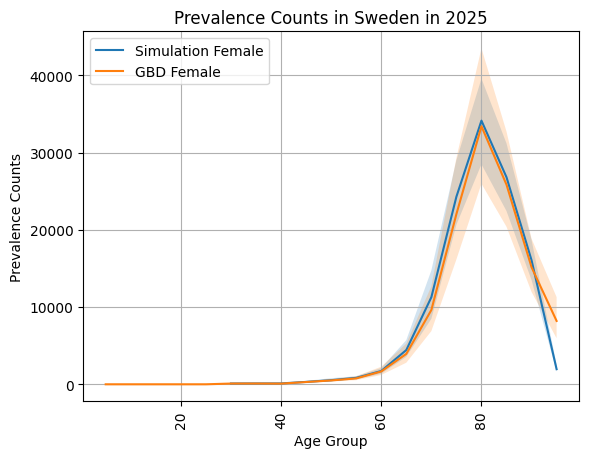

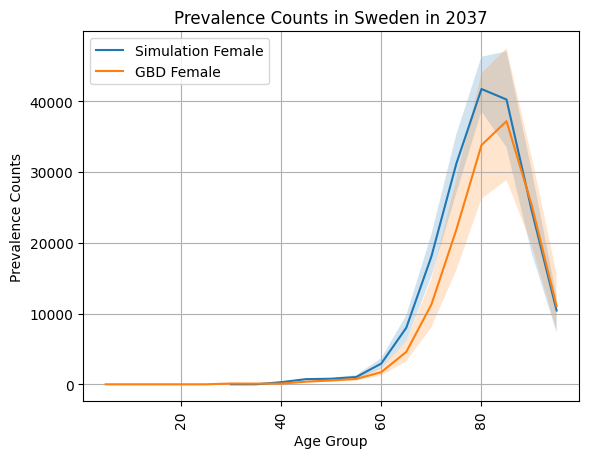

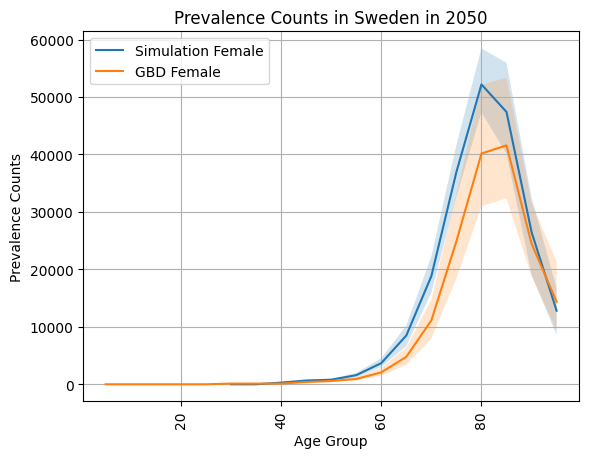

<Figure size 640x480 with 0 Axes>

In [ ]:
for location in new_sims.location.unique():
    for year in [2025, 2037, 2050]:
        for sex in new_sims.sex.unique()[:1]:
            plot_data = new_sims.loc[
                (new_sims.location == location)
                & (new_sims.event_year == year)
                & (new_sims.sex == sex)
            ]
            #             gbd_plot = gbd_data.loc[(gbd_data.location_name == location) & (gbd_data.sex == sex) & (gbd_data.measure == 'prevalence')]

            location_w_spaces = location.replace("_", " ").replace("Of", "of")
            art_plot = art_prev_data.query(
                f'location == "{location_w_spaces}" and year_start == {year} and sex == "{sex}"'
            ).reset_index()
            art_plot["mean"] = art_plot.filter(like="draw_").mean(axis=1)
            art_plot["upper"] = np.percentile(
                art_plot.filter(like="draw_"), 97.5, axis=1
            )
            art_plot["lower"] = np.percentile(
                art_plot.filter(like="draw_"), 2.5, axis=1
            )

            plt.plot(plot_data.age_start, plot_data["mean"], label=f"Simulation {sex}")
            plt.fill_between(
                plot_data.age_start, plot_data["2.5%"], plot_data["97.5%"], alpha=0.2
            )

            plt.plot(art_plot.age_start, art_plot["mean"], label=f"GBD {sex}")
            plt.fill_between(
                art_plot.age_start, art_plot["upper"], art_plot["lower"], alpha=0.2
            )

            plt.title(f"Prevalence Counts in {location} in {year}")
            plt.tick_params(axis="x", labelrotation=90)
            plt.xlabel("Age Group")
            plt.ylabel(f"Prevalence Counts")
            plt.legend()
            plt.grid()
        #             plt.semilogy()
        plt.figure()

# Dementia Prevalence

In [54]:
# swtich from this
# art.load(
#     'population.scaling_factor'
#         )#.droplevel(['year_start', 'year_end'])

# to this
# art.load(
#     'cause.alzheimers.prevalence'
#         )#.droplevel(['year_start', 'year_end'])

# ?

In [ ]:
art_prev_data = []
for artifact_dir in artifact_dirs:
    art = Artifact(artifact_dir)
    df = pd.merge(
        art.load("cause.alzheimers.prevalence").droplevel(["year_start", "year_end"]),
        art.load("population.structure"),
        left_index=True,
        right_index=True,
        suffixes=["", "_pop"],
    )
    art_prev_data.append(df)

art_prev_data = pd.concat(art_prev_data)
for i in range(500):
    art_prev_data[f"draw_{i}"] *= art_prev_data[f"draw_{i}_pop"]
    del art_prev_data[f"draw_{i}_pop"]


art_prev_data

draw_0  \
sex    age_start age_end location year_start year_end                
Female 5.0       10.0    Sweden   2021       2022         0.000000   
                                  2022       2023         0.000000   
                                  2023       2024         0.000000   
                                  2024       2025         0.000000   
                                  2025       2026         0.000000   
...                                                            ...   
Male   95.0      125.0   Sweden   2046       2047      2511.232006   
                                  2047       2048      2512.534852   
                                  2048       2049      2513.192448   
                                  2049       2050      2509.233258   
                                  2050       2051      2501.806281   

                                                            draw_1  \
sex    age_start age_end location year_start year_end                
Female 5.0       10.0    Sweden   2021       2022         0.000000   
                                  2022       2023         0.000000   
                                  2023       2024         0.000000   
                                  2024       2025         0.000000   
                                  2025       2026         0.000000   
...                                                            ...   
Male   95.0      125.0   Sweden   2046       2047      1921.989629   
                                  2047       2048      1926.583632   
                                  2048       2049      1922.975401   
                                  2049       2050      1915.593887   
                                  2050       2051      1913.161807   

                                                            draw_2  \
sex    age_start age_end location year_start year_end                
Female 5.0       10.0    Sweden   2021       2022         0.000000   
                                  2022       2023         0.000000   
                                  2023       2024         0.000000   
                                  2024       2025         0.000000   
                                  2025       2026         0.000000   
...                                                            ...   
Male   95.0      125.0   Sweden   2046       2047      2277.096103   
                                  2047       2048      2284.542226   
                                  2048       2049      2289.990482   
                                  2049       2050      2295.559268   
                                  2050       2051      2298.985301   

                                                            draw_3  \
sex    age_start age_end location year_start year_end                
Female 5.0       10.0    Sweden   2021       2022         0.000000   
                                  2022       2023         0.000000   
                                  2023       2024         0.000000   
                                  2024       2025         0.000000   
                                  2025       2026         0.000000   
...                                                            ...   
Male   95.0      125.0   Sweden   2046       2047      2586.841860   
                                  2047       2048      2612.218484   
                                  2048       2049      2625.219984   
                                  2049       2050      2634.840755   
                                  2050       2051      2653.327705   

                                                            draw_4  \
sex    age_start age_end location year_start year_end                
Female 5.0       10.0    Sweden   2021       2022         0.000000   
                                  2022       2023         0.000000   
                                  2023       2024         0.000000   
                                  2024       2025         0.000000

In [56]:
# t[t.sub_entity == 'alzheimers_disease_state']

In [ ]:
cols = ["input_draw", "event_year", "location", "age_group", "sex"]

new_sims = load_df("person_time_alzheimers_disease_and_other_dementias")

# restrict to dementia state only
new_sims = new_sims[new_sims.sub_entity == "alzheimers_disease_state"]

new_sims = new_sims.merge(
    scale[["location", "sex", "age_group", "ratio", "event_year"]]
)
new_sims["total_prev"] = new_sims["value"] / new_sims["ratio"]
new_sims = new_sims.groupby(cols).sum(numeric_only=True)
new_sims = (
    new_sims.groupby([c for c in cols if c != "input_draw"])
    .describe(percentiles=[0.025, 0.975])["total_prev"]
    .reset_index()
)

new_sims = new_sims.merge(age_dictionary, on=["age_group"])
new_sims = new_sims.loc[new_sims["age_group_id"].isin(age_group_ids)]
new_sims.tail()

/tmp/ipykernel_3574311/642622834.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = temp.groupby(cols)['value'].sum().reset_index()


,event_year,location,age_group,sex,count,mean,std,min,2.5%,50%,97.5%,max,Unnamed: 0,age_group_id,age_group_name,age_start,age_end
723,2050,Sweden,85_to_89,Male,25.0,14472.152656,2137.489735,9799.812998,11102.498073,14588.549241,18266.645918,18603.079884,22,31,85 to 89,85.0,90.0
724,2050,Sweden,90_to_94,Female,25.0,19690.546433,3439.042992,13421.040109,13591.117312,19898.146919,24170.627986,24406.078614,23,32,90 to 94,90.0,95.0
725,2050,Sweden,90_to_94,Male,25.0,7717.961736,1648.977546,4323.681392,5170.878459,7780.146213,10437.956836,10531.499297,23,32,90 to 94,90.0,95.0
726,2050,Sweden,95_plus,Female,25.0,10273.478008,2662.441001,6277.797588,6340.513556,10515.554560,14019.499267,14037.569969,24,235,95 plus,95.0,125.0
727,2050,Sweden,95_plus,Male,25.0,4273.402319,1476.088627,1925.769995,2308.975193,3602.624917,6906.197420,7114.010502,24,235,95 plus,95.0,125.0


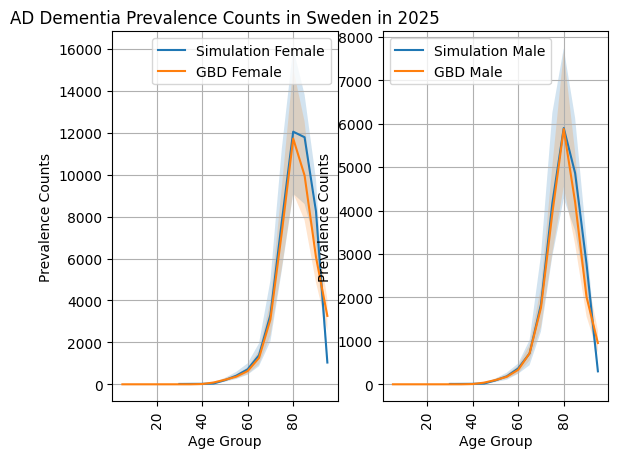

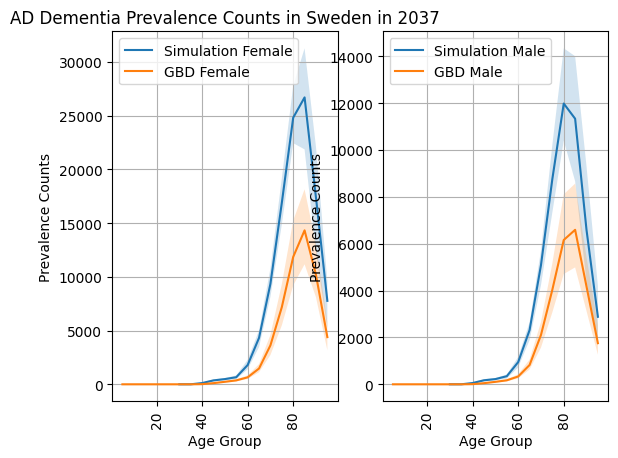

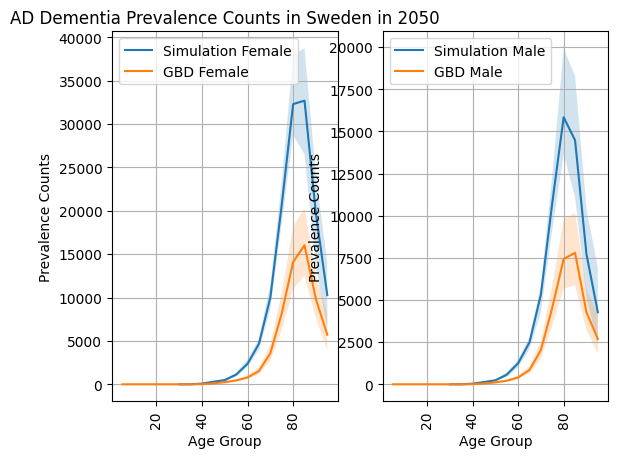

<Figure size 640x480 with 0 Axes>

In [ ]:
for location in new_sims.location.unique():
    for year in [2025, 2037, 2050]:
        for i, sex in enumerate(new_sims.sex.unique()):
            plt.subplot(1, 2, i + 1)
            plot_data = new_sims.loc[
                (new_sims.location == location)
                & (new_sims.event_year == year)
                & (new_sims.sex == sex)
            ]
            #             gbd_plot = gbd_data.loc[(gbd_data.location_name == location) & (gbd_data.sex == sex) & (gbd_data.measure == 'prevalence')]

            location_w_spaces = location.replace("_", " ").replace("Of", "of")
            art_plot = art_prev_data.query(
                f'location == "{location_w_spaces}" and year_start == {year} and sex == "{sex}"'
            ).reset_index()
            art_plot["mean"] = art_plot.filter(like="draw_").mean(axis=1)
            art_plot["upper"] = np.percentile(
                art_plot.filter(like="draw_"), 97.5, axis=1
            )
            art_plot["lower"] = np.percentile(
                art_plot.filter(like="draw_"), 2.5, axis=1
            )

            plt.plot(plot_data.age_start, plot_data["mean"], label=f"Simulation {sex}")
            plt.fill_between(
                plot_data.age_start, plot_data["2.5%"], plot_data["97.5%"], alpha=0.2
            )

            plt.plot(art_plot.age_start, art_plot["mean"], label=f"GBD {sex}")
            plt.fill_between(
                art_plot.age_start, art_plot["upper"], art_plot["lower"], alpha=0.2
            )

            if i == 0:
                plt.title(f"AD Dementia Prevalence Counts in {location} in {year}")
            plt.tick_params(axis="x", labelrotation=90)
            plt.xlabel("Age Group")
            plt.ylabel(f"Prevalence Counts")
            plt.legend()
            plt.grid()
        #             plt.semilogy()
        plt.figure()

## Total Sim Population Over Time

In [ ]:
cols = ["input_draw", "event_year", "location"]  # , 'age_group']

person_time_total = load_df("person_time_alzheimers_disease_and_other_dementias")
person_time_total = person_time_total.groupby(cols)["value"].sum().reset_index()
person_time_total = (
    person_time_total.groupby([c for c in cols if c != "input_draw"])["value"]
    .describe(percentiles=[0.025, 0.975])
    .reset_index()
)
person_time_total  # .head()

/tmp/ipykernel_3574311/642622834.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = temp.groupby(cols)['value'].sum().reset_index()


,event_year,location,count,mean,std,min,2.5%,50%,97.5%,max
0,2025,Sweden,25.0,101203.719754,210.345093,100777.423682,100828.249144,101189.010267,101569.104997,101592.125941
1,2026,Sweden,25.0,107119.265380,929.339232,105519.638604,105538.772895,106975.638604,108843.623819,108904.016427
2,2027,Sweden,25.0,112622.467023,1661.945854,109915.542779,110030.647502,112114.491444,115759.275017,115923.411362
3,2028,Sweden,25.0,117689.526407,2355.135975,114040.377823,114127.379055,116981.776865,122184.012047,122406.149213
4,2029,Sweden,25.0,122327.917864,2977.497951,117815.912389,117964.502122,121716.019165,127916.924846,128409.034908
5,2030,Sweden,25.0,126624.941602,3632.462934,121119.567420,121189.228200,125966.921287,133308.509788,133910.642026
6,2031,Sweden,25.0,130635.030691,4239.114494,124144.678987,124279.216975,129886.461328,138440.884873,139029.563313
7,2032,Sweden,25.0,134337.476249,4802.131581,126846.899384,127132.119918,133251.904175,143141.741821,143696.038330
8,2033,Sweden,25.0,137696.899767,5279.714431,129484.342231,129771.057632,136899.876797,147210.369884,147678.861054
9,2034,Sweden,25.0,140769.667680,5774.900448,131543.271732,132081.124709,140575.753593,150882.260370,151098.119097


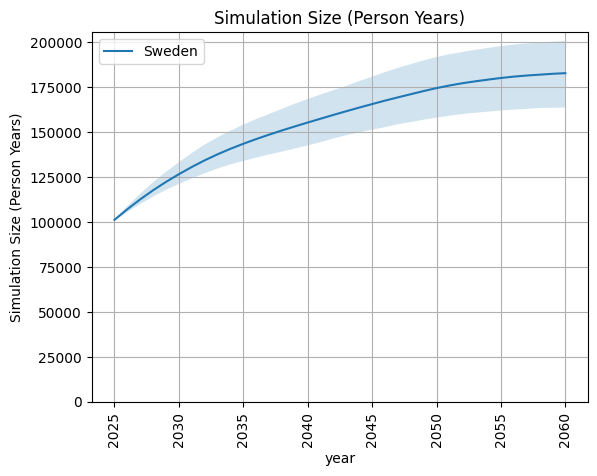

In [ ]:
for location in person_time_total.location.unique():
    plot_data = person_time_total.loc[(person_time_total.location == location)]
    plt.plot(plot_data.event_year, plot_data["mean"], label=location)
    plt.fill_between(
        plot_data.event_year, plot_data["2.5%"], plot_data["97.5%"], alpha=0.2
    )
    plt.title(f"Simulation Size (Person Years)")
    plt.tick_params(axis="x", labelrotation=90)
    plt.xlabel("year")
    plt.ylabel("Simulation Size (Person Years)")
    plt.legend()
    plt.axis(ymin=0)
    plt.grid()

# Decompose person-time by state

In [ ]:
cols = ["input_draw", "event_year", "sub_entity", "location"]  # , 'age_group']

person_time_total = load_df("person_time_alzheimers_disease_and_other_dementias")
person_time_total = person_time_total.groupby(cols)["value"].sum().reset_index()
person_time_total = (
    person_time_total.groupby([c for c in cols if c != "input_draw"])["value"]
    .describe(percentiles=[0.025, 0.975])
    .reset_index()
)
person_time_total  # .head()

/tmp/ipykernel_3574311/642622834.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = temp.groupby(cols)['value'].sum().reset_index()
/tmp/ipykernel_3574311/1445989731.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  person_time_total = person_time_total.groupby(cols)['value'].sum().reset_index()
/tmp/ipykernel_3574311/1445989731.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  person_time_total = person_tim

,event_year,sub_entity,location,count,mean,std,min,2.5%,50%,97.5%,max
0,2025,alzheimers_blood_based_biomarker_state,Sweden,25.0,42028.770431,831.204253,40503.906913,40830.385763,41916.555784,43681.594524,43914.195756
1,2025,alzheimers_disease_state,Sweden,25.0,38381.874114,848.233663,36392.525667,36649.343737,38445.973990,39672.960438,39731.559206
2,2025,alzheimers_mild_cognitive_impairment_state,Sweden,25.0,20793.075209,259.664928,20180.199863,20241.190418,20802.562628,21163.622724,21293.377139
3,2026,alzheimers_blood_based_biomarker_state,Sweden,25.0,39798.728542,1028.111877,37616.323066,37887.192882,39697.675565,41715.147433,41969.872690
4,2026,alzheimers_disease_state,Sweden,25.0,44374.016701,1114.997930,41803.444216,42183.439288,44509.152635,46560.607803,46762.414784
...,...,...,...,...,...,...,...,...,...,...,...
103,2059,alzheimers_disease_state,Sweden,25.0,117578.228611,11415.287928,94262.297057,98376.169747,118726.784394,133749.296099,134588.813142
104,2059,alzheimers_mild_cognitive_impairment_state,Sweden,25.0,28522.352361,1257.659275,25514.381930,25931.449692,28560.421629,30350.175496,31137.073238
105,2060,alzheimers_blood_based_biomarker_state,Sweden,25.0,36452.140945,2533.767610,29509.163587,30955.895414,37158.893908,40011.099247,41036.577687
106,2060,alzheimers_disease_state,Sweden,25.0,117915.669815,11486.799884,94277.245722,98447.624367,119195.175907,134256.155510,135138.425736


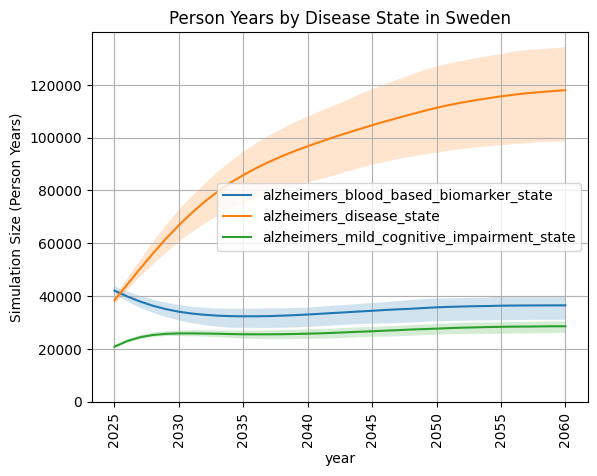

In [ ]:
for location in person_time_total.location.unique():
    for sub_entity in person_time_total.sub_entity.unique():
        plot_data = person_time_total.query(
            "location == @location and sub_entity == @sub_entity"
        )
        plt.plot(plot_data.event_year, plot_data["mean"], label=sub_entity)
        plt.fill_between(
            plot_data.event_year, plot_data["2.5%"], plot_data["97.5%"], alpha=0.2
        )
    plt.title(f"Person Years by Disease State in {location}")
    plt.tick_params(axis="x", labelrotation=90)
    plt.xlabel("year")
    plt.ylabel("Simulation Size (Person Years)")
    plt.legend()
    plt.axis(ymin=0)
    plt.grid()

# Did the fix to initialization work?  Seems so